In [1]:
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict

import feather
import numpy as np 
import pandas as pd
from sklearn import *
import lightgbm as lgb
from catboost import Pool,CatBoostRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

pd.set_option("display.precision", 8)

from functools import partial
import scipy as sp

import os
from sklearn.metrics import f1_score

import pywt 
from statsmodels.robust import mad

import scipy
from scipy import signal
from scipy.signal import butter, deconvolve, find_peaks, peak_widths, peak_prominences

from numpy.fft import *

import time
import math
from numba import jit
from math import log, floor
from sklearn.neighbors import KDTree

import itertools
import warnings
import time
import pywt
import os
import gc

train = pd.read_csv('/Users/siero5335/channel/train.csv')
test = pd.read_csv('/Users/siero5335/channel/test.csv')
train2 = pd.read_csv('/Users/siero5335/channel/train2.csv')
test2 = pd.read_csv('/Users/siero5335/channel/test2.csv')


sample_submission = pd.read_csv('/Users/siero5335/channel/sample_submission.csv')

train2 = train2.iloc[:,1]
test2 = test2.iloc[:,1]

train = pd.concat([train, train2], axis=1)
test = pd.concat([test, test2], axis=1)

In [2]:
train = train.drop('signal', axis = 1)
test = test.drop('signal', axis = 1)

train = train.rename(columns={'signal_chris': 'signal'})
test = test.rename(columns={'signal_chris': 'signal'})

del train2, test2
gc.collect()

37

In [3]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=1000, sample_rate=10000):

    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    print(norm_low_cutoff)
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

def denoise_signal( x, wavelet='db4', level=1):
    
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    sigma = (1/0.6745) * maddest( coeff[-level] )
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    return pywt.waverec( coeff, wavelet, mode='per' )

train['signal_wave'] = denoise_signal(train['signal'])
test['signal_wave'] = denoise_signal(test['signal'])

In [4]:
def filter_signal(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

train['signal_FFT_1e5'] = filter_signal(train['signal'], threshold=5e3)
test['signal_FFT_1e5'] = filter_signal(test['signal'], threshold=5e3)

In [5]:
def _embed(x, order=3, delay=1):
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

all = ['perm_entropy', 'spectral_entropy', 'svd_entropy', 'app_entropy',
       'sample_entropy']


def perm_entropy(x, order=3, delay=1, normalize=False):
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe

In [6]:
def _log_n(min_n, max_n, factor):
    max_i = int(floor(log(1.0 * max_n / min_n) / log(factor)))
    ns = [min_n]
    for i in range(max_i + 1):
        n = int(floor(min_n * (factor ** i)))
        if n > ns[-1]:
            ns.append(n)
    return np.array(ns, dtype=np.int64)

def _higuchi_fd(x, kmax):
    n_times = x.size
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
        # Mean of lm
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        m_lm /= k
        lk[k - 1] = m_lm
        x_reg[k - 1] = log(1. / k)
        y_reg[k - 1] = log(m_lm)
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi


def higuchi_fd(x, kmax=10):
    x = np.asarray(x, dtype=np.float64)
    kmax = int(kmax)
    return _higuchi_fd(x, kmax)

def _linear_regression(x, y):
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    return slope, intercept

In [7]:
def katz_fd(x):
    x = np.array(x)
    dists = np.abs(np.ediff1d(x))
    ll = dists.sum()
    ln = np.log10(np.divide(ll, dists.mean()))
    aux_d = x - x[0]
    d = np.max(np.abs(aux_d[1:]))
    return np.divide(ln, np.add(ln, np.log10(np.divide(d, ll))))

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (
                start_mem - end_mem) / start_mem))
    return df

In [9]:
def p1( x : pd.Series) -> pd.Series : return x.quantile(0.01)
def p99(x : pd.Series) -> pd.Series : return x.quantile(0.99)

window_sizes = [5, 50, 100, 500, 1000, 5000]
batch_sizes = [5000, 10000, 25000, 50000]
zscore = lambda x: (x - x.mean()) / x.std()

train_y = train['open_channels']

In [10]:
def generate_features(data: pd.DataFrame,
                      batch_sizes: list,
                      window_sizes: list) -> pd.DataFrame:
    """
    Generate features for https://www.kaggle.com/c/liverpool-ion-switching

    Generate various aggregations over the data.

    Args:
        window_sizes: window sizes for rolling features
        batch_sizes: batch sizes for which features are aggregated
        data: original dataframe

    Returns:
        dataframe with generated features
    """
    for batch_size in batch_sizes:
        data['batch'] = ((data['time'] * 10_000) - 1) // batch_size
        data['batch_index'] = ((data['time'] * 10_000) - 1) - (data['batch'] * batch_size)
        data['batch_slices'] = data['batch_index'] // (batch_size / 10)
        data['batch_slices2'] = data['batch'].astype(str).str.zfill(3) + '_' + data['batch_slices'].astype(
            str).str.zfill(3)
        data['batch_slices3'] = data['batch_index'] // (batch_size / 5)
        data['batch_slices4'] = data['batch'].astype(str).str.zfill(3) + '_' + data['batch_slices3'].astype(
            str).str.zfill(3)

        for agg_feature in ['batch', 'batch_slices2', 'batch_slices3']:
            data[f"min_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].transform('min')
            data[f"max_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].transform('max')
            data[f"std_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].transform('std')
            data[f"mean_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].transform('mean')
            data[f"median_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].transform('median')
            
            data[f"q1_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(lambda x:p1(x))      
            data[f"q99_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(lambda x:p99(x))                   
        
            data[f"zscore_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].transform(zscore)
            data[f"perm_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(lambda x:perm_entropy(x))
            data[f" higuchi_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(lambda x:higuchi_fd(x))
            data[f" katz_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(lambda x:katz_fd(x))

            data[f"mean_abs_chg_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(
                lambda x: np.mean(np.abs(np.diff(x))))
            data[f"abs_max_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(
                lambda x: np.max(np.abs(x)))
            data[f"abs_min_{agg_feature}_{batch_size}"] = data.groupby(agg_feature)['signal'].apply(
                lambda x: np.min(np.abs(x)))

            data[f"min_{agg_feature}_{batch_size}_diff"] = data[f"min_{agg_feature}_{batch_size}"] - data['signal']
            data[f"max_{agg_feature}_{batch_size}_diff"] = data[f"max_{agg_feature}_{batch_size}"] - data['signal']
            data[f"std_{agg_feature}_{batch_size}_diff"] = data[f"std_{agg_feature}_{batch_size}"] - data['signal']
            data[f"mean_{agg_feature}_{batch_size}_diff"] = data[f"mean_{agg_feature}_{batch_size}"] - data['signal']
            data[f"median_{agg_feature}_{batch_size}_diff"] = data[f"median_{agg_feature}_{batch_size}"] - data[
                'signal']

            data[f"range_{agg_feature}_{batch_size}"] = data[f"max_{agg_feature}_{batch_size}"] - data[
                f"min_{agg_feature}_{batch_size}"]
            data[f"maxtomin_{agg_feature}_{batch_size}"] = data[f"max_{agg_feature}_{batch_size}"] / data[
                f"min_{agg_feature}_{batch_size}"]
            data[f"abs_avg_{agg_feature}_{batch_size}"] = (data[f"abs_min_{agg_feature}_{batch_size}"] + data[
                f"abs_max_{agg_feature}_{batch_size}"]) / 2

            data[f'signal_shift+1_{agg_feature}_{batch_size}'] = data.groupby([agg_feature]).shift(1)['signal']
            data[f'signal_shift-1_{agg_feature}_{batch_size}'] = data.groupby([agg_feature]).shift(-1)['signal']
            data[f'signal_shift+2_{agg_feature}_{batch_size}'] = data.groupby([agg_feature]).shift(2)['signal']
            data[f'signal_shift-2_{agg_feature}_{batch_size}'] = data.groupby([agg_feature]).shift(-2)['signal']

            data[f"signal_shift+1_{agg_feature}_{batch_size}_diff"] = data[f"signal_shift+1_{agg_feature}_{batch_size}"] - data['signal']
            data[f"signal_shift-1_{agg_feature}_{batch_size}_diff"] = data[f"signal_shift-1_{agg_feature}_{batch_size}"] - data['signal']
            data[f"signal_shift+2_{agg_feature}_{batch_size}_diff"] = data[f"signal_shift+2_{agg_feature}_{batch_size}"] - data['signal']
            data[f"signal_shift-2_{agg_feature}_{batch_size}_diff"] = data[f"signal_shift-2_{agg_feature}_{batch_size}"] - data['signal']

        for window in window_sizes:
            window = min(batch_size, window)

            data["rolling_mean_" + str(window) + '_batch_' + str(batch_size)] = \
                data.groupby('batch')['signal'].rolling(window=window).mean().reset_index()['signal']
            data["rolling_std_" + str(window) + '_batch_' + str(batch_size)] = \
                data.groupby('batch')['signal'].rolling(window=window).std().reset_index()['signal']
            data["rolling_min_" + str(window) + '_batch_' + str(batch_size)] = \
                data.groupby('batch')['signal'].rolling(window=window).min().reset_index()['signal']
            data["rolling_max_" + str(window) + '_batch_' + str(batch_size)] = \
                data.groupby('batch')['signal'].rolling(window=window).max().reset_index()['signal']

            data[f'exp_Moving__{window}_{batch_size}'] = data.groupby('batch')['signal'].apply(
                lambda x: x.ewm(alpha=0.5, adjust=False).mean())
        data = reduce_mem_usage(data)
    data.fillna(0, inplace=True)

    return data

In [11]:
train = generate_features(train, batch_sizes, window_sizes)
test = generate_features(test, batch_sizes, window_sizes)

Mem. usage decreased to 1587.87 Mb (68.2% reduction)


/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning:

overflow encountered in reduce

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in log10

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in add



Mem. usage decreased to 3046.99 Mb (30.8% reduction)


/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning:

overflow encountered in reduce

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in log10

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in add



Mem. usage decreased to 4534.72 Mb (22.6% reduction)


/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning:

overflow encountered in reduce

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in log10

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in add



Mem. usage decreased to 6022.45 Mb (18.0% reduction)
Mem. usage decreased to 621.80 Mb (68.7% reduction)


/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning:

overflow encountered in reduce

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in log10

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in add



Mem. usage decreased to 1194.00 Mb (31.7% reduction)


/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning:

overflow encountered in reduce

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in log10

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in add



Mem. usage decreased to 1789.09 Mb (22.9% reduction)


/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning:

overflow encountered in reduce

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in log10

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in add



Mem. usage decreased to 2384.19 Mb (18.2% reduction)


In [12]:
train.head()

,time,open_channels,signal,signal_wave,signal_FFT_1e5,batch,batch_index,batch_slices,batch_slices2,batch_slices3,...,rolling_mean_1000_batch_50000,rolling_std_1000_batch_50000,rolling_min_1000_batch_50000,rolling_max_1000_batch_50000,exp_Moving__1000_50000,rolling_mean_5000_batch_50000,rolling_std_5000_batch_50000,rolling_min_5000_batch_50000,rolling_max_5000_batch_50000,exp_Moving__5000_50000
0,0.00010002,0,-2.75976562,-2.50000000,0.36743164,0.0,0.00016594,0.0,0.0_0.0,0.0,...,0.0,0.0,0.0,0.0,-2.75976562,0.0,0.0,0.0,0.0,-2.75976562
1,0.00020003,0,-2.85546875,-3.54492188,0.36718750,0.0,1.00000000,0.0,0.0_0.0,0.0,...,0.0,0.0,0.0,0.0,-2.80859375,0.0,0.0,0.0,0.0,-2.80859375
2,0.00029993,0,-2.40820312,-0.95410156,0.36694336,0.0,1.99902344,0.0,0.0_0.0,0.0,...,0.0,0.0,0.0,0.0,-2.60742188,0.0,0.0,0.0,0.0,-2.60742188
3,0.00040007,0,-3.14062500,-1.32910156,0.36669922,0.0,3.00000000,0.0,0.0_0.0,0.0,...,0.0,0.0,0.0,0.0,-2.87500000,0.0,0.0,0.0,0.0,-2.87500000
4,0.00050020,0,-3.15234375,-3.60546875,0.36645508,0.0,4.00390625,0.0,0.0_0.0,0.0,...,0.0,0.0,0.0,0.0,-3.01367188,0.0,0.0,0.0,0.0,-3.01367188


In [13]:
test.head()

,time,signal,signal_wave,signal_FFT_1e5,batch,batch_index,batch_slices,batch_slices2,batch_slices3,batch_slices4,...,rolling_mean_1000_batch_50000,rolling_std_1000_batch_50000,rolling_min_1000_batch_50000,rolling_max_1000_batch_50000,exp_Moving__1000_50000,rolling_mean_5000_batch_50000,rolling_std_5000_batch_50000,rolling_min_5000_batch_50000,rolling_max_5000_batch_50000,exp_Moving__5000_50000
0,500.0,-2.65039062,-2.70703125,-2.68945312,99.0,49984.0,9.0,99.0_9.0,4.0,99.0_4.0,...,0.0,0.0,0.0,0.0,-2.65039062,0.0,0.0,0.0,0.0,-2.65039062
1,500.0,-2.84960938,-2.70703125,-2.68945312,99.0,49984.0,9.0,99.0_9.0,4.0,99.0_4.0,...,0.0,0.0,0.0,0.0,-2.75000000,0.0,0.0,0.0,0.0,-2.75000000
2,500.0,-2.85937500,-2.70703125,-2.68945312,99.0,49984.0,9.0,99.0_9.0,4.0,99.0_4.0,...,0.0,0.0,0.0,0.0,-2.80468750,0.0,0.0,0.0,0.0,-2.80468750
3,500.0,-2.43554688,-2.70703125,-2.68945312,99.0,49984.0,9.0,99.0_9.0,4.0,99.0_4.0,...,0.0,0.0,0.0,0.0,-2.62109375,0.0,0.0,0.0,0.0,-2.62109375
4,500.0,-2.61523438,-2.70703125,-2.68945312,99.0,49984.0,9.0,99.0_9.0,4.0,99.0_4.0,...,0.0,0.0,0.0,0.0,-2.61718750,0.0,0.0,0.0,0.0,-2.61718750


In [14]:
import argparse

In [15]:
train.to_csv('/Users/siero5335/channel/train_mod.csv')
test.to_csv('/Users/siero5335/channel/test_mod.csv')

In [16]:
gc.collect()

22

In [17]:
col = [c for c in train.columns if c not in ['time', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2', 'batch_slices3', 'batch_slices4']]

train = train[col]
test = test[col]

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [18]:
model_cat = CatBoostRegressor(task_type = "CPU",
                          iterations=5000,
                          learning_rate=0.2,
                          random_seed = 71,
                          depth=7,
                          eval_metric='MAE',
                          early_stopping_rounds = 10,
                          verbose=100)

In [19]:
oof_cat = np.zeros(len(train))
prediction_cat = np.zeros(len(test))
scores = []

for i, (train_index, valid_index) in enumerate(folds.split(train, train_y)):
    
    # Create data for this fold
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    print( "\nFold ", i)
    
    # Run model for this fold

    fit_model = model_cat.fit( X_train, y_train, 
                               eval_set=(X_valid, y_valid),
                               use_best_model=True
                             )

        
    # Generate validation predictions for this fold
    y_pred_valid_cat = fit_model.predict(X_valid)
    y_pred_cat = fit_model.predict(test)

    oof_cat[valid_index] = y_pred_valid_cat.reshape(-1,)
    scores.append(mean_absolute_error(y_valid, y_pred_valid_cat))

    prediction_cat += y_pred_cat

prediction_cat /= n_fold


Fold  0
0:	learn: 1.7588817	test: 1.7588909	best: 1.7588909 (0)	total: 4.13s	remaining: 5h 44m 5s
100:	learn: 0.0740319	test: 0.0740984	best: 0.0740984 (100)	total: 5m 11s	remaining: 4h 12m 3s
200:	learn: 0.0665682	test: 0.0667271	best: 0.0667271 (200)	total: 10m 6s	remaining: 4h 1m 17s
300:	learn: 0.0630137	test: 0.0632706	best: 0.0632706 (300)	total: 14m 59s	remaining: 3h 54m 4s
400:	learn: 0.0610825	test: 0.0614642	best: 0.0614642 (400)	total: 19m 47s	remaining: 3h 47m 3s
500:	learn: 0.0597701	test: 0.0602834	best: 0.0602834 (500)	total: 24m 36s	remaining: 3h 40m 57s
600:	learn: 0.0588364	test: 0.0594915	best: 0.0594915 (600)	total: 29m 20s	remaining: 3h 34m 44s
700:	learn: 0.0580310	test: 0.0588259	best: 0.0588259 (700)	total: 34m	remaining: 3h 28m 33s
800:	learn: 0.0574221	test: 0.0583480	best: 0.0583480 (800)	total: 38m 45s	remaining: 3h 23m 10s
900:	learn: 0.0569466	test: 0.0580170	best: 0.0580170 (900)	total: 43m 19s	remaining: 3h 17m 7s
1000:	learn: 0.0565273	test: 0.0577282	

In [20]:
oof = np.zeros(len(train))
prediction = np.zeros(len(test))
scores = []

params = {'learning_rate': 0.05, 'max_depth': -1, 'num_leaves':2**7+1, 'metric': 'mae', 'random_state': 7, 'n_jobs':-1} 

for fold_n, (train_index, valid_index) in enumerate(folds.split(train, train_y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    
    model = lgb.LGBMRegressor(**params, n_estimators = 10000)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
            verbose=100, early_stopping_rounds=50)

    y_pred_valid = model.predict(X_valid)
    y_pred = model.predict(test, num_iteration=model.best_iteration_)

    oof[valid_index] = y_pred_valid.reshape(-1,)
    scores.append(mean_absolute_error(y_valid, y_pred_valid))

    prediction += y_pred

prediction /= n_fold

Fold 0 started at Wed Mar 11 07:14:11 2020
Training until validation scores don't improve for 50 rounds
[100]	training's l1: 0.0577938	valid_1's l1: 0.0581198
[200]	training's l1: 0.0500039	valid_1's l1: 0.0507477
[300]	training's l1: 0.0494875	valid_1's l1: 0.0506272
[400]	training's l1: 0.0490365	valid_1's l1: 0.0505497
[500]	training's l1: 0.0486434	valid_1's l1: 0.0505045
[600]	training's l1: 0.0482745	valid_1's l1: 0.050465
[700]	training's l1: 0.0479286	valid_1's l1: 0.0504476
[800]	training's l1: 0.0475725	valid_1's l1: 0.0504236
[900]	training's l1: 0.0472235	valid_1's l1: 0.0503998
[1000]	training's l1: 0.0468762	valid_1's l1: 0.0503818
[1100]	training's l1: 0.0465295	valid_1's l1: 0.0503578
[1200]	training's l1: 0.0462116	valid_1's l1: 0.0503334
[1300]	training's l1: 0.0458991	valid_1's l1: 0.0503236
[1400]	training's l1: 0.0455915	valid_1's l1: 0.0503122
[1500]	training's l1: 0.0452801	valid_1's l1: 0.0502976
[1600]	training's l1: 0.0449676	valid_1's l1: 0.0502913
Early stop

In [21]:
prediction = 0.8 * prediction + 0.2 * prediction_cat
oof = 0.8 * oof + 0.2 * oof_cat

In [22]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize F1 (Macro) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _f1_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

        return -f1_score(y, X_p, average = 'macro')

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._f1_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [23]:
optR = OptimizedRounder()
optR.fit(oof.reshape(-1,), train_y)
coefficients = optR.coefficients()
print(coefficients)

[0.50897512 1.50911071 2.52330883 3.49891267 4.50963702 5.46779651
 6.51415017 7.50110315 8.47384318 9.47894756]


In [24]:
opt_preds = optR.predict(oof.reshape(-1,), coefficients)
f1_score(train_y, opt_preds, average = 'macro')

0.9381243339029194

In [25]:
prediction[prediction <= coefficients[0]] = 0
prediction[np.where(np.logical_and(prediction > coefficients[0], prediction <= coefficients[1]))] = 1
prediction[np.where(np.logical_and(prediction > coefficients[1], prediction <= coefficients[2]))] = 2
prediction[np.where(np.logical_and(prediction > coefficients[2], prediction <= coefficients[3]))] = 3
prediction[np.where(np.logical_and(prediction > coefficients[3], prediction <= coefficients[4]))] = 4
prediction[np.where(np.logical_and(prediction > coefficients[4], prediction <= coefficients[5]))] = 5
prediction[np.where(np.logical_and(prediction > coefficients[5], prediction <= coefficients[6]))] = 6
prediction[np.where(np.logical_and(prediction > coefficients[6], prediction <= coefficients[7]))] = 7
prediction[np.where(np.logical_and(prediction > coefficients[7], prediction <= coefficients[8]))] = 8
prediction[np.where(np.logical_and(prediction > coefficients[8], prediction <= coefficients[9]))] = 9
prediction[prediction > coefficients[9]] = 10

In [26]:
sample_submission['open_channels'] = prediction.astype(np.int)
sample_submission.to_csv('submission_reg20200307_mae_5cv_f.csv', index=False, float_format='%.4f')

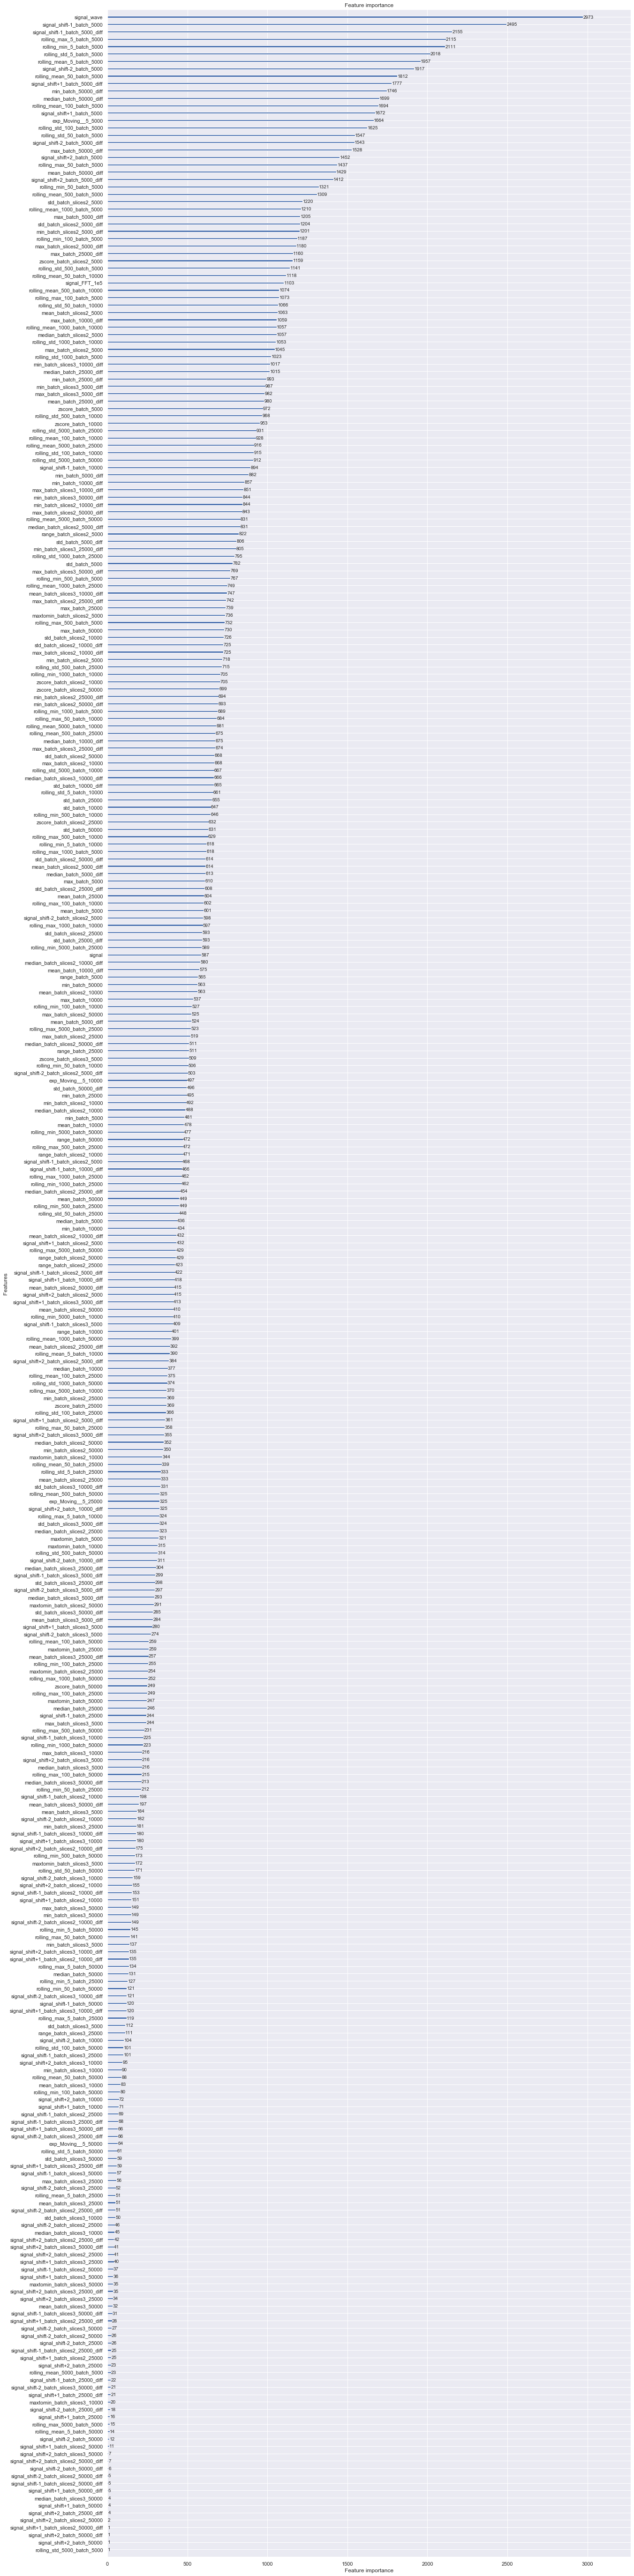

In [28]:
lgb.plot_importance(model,importance_type='split', max_num_features=500, figsize=(20, 100))